# AT-BLSTM for Twitter

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
from __future__ import print_function
import sys

In [3]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [4]:
import re
import pandas as pd
import numpy as np

In [5]:
import pandas as pd
import keras.layers as layers
import tensorflow as tf
import tensorflow_hub as hub
import pydot
import itertools
import h5py
import keras.callbacks
import tensorflow as tf
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.regularizers import l2
from AdamW import AdamW
from keras.layers import Input, Embedding, LSTM, Dense, Activation, Dropout, Flatten, merge
from keras.models import Model
from keras.layers import Conv1D, MaxPooling1D,AveragePooling1D, GlobalMaxPooling1D, concatenate
from keras.layers import TimeDistributed, Bidirectional, Lambda
from keras.layers import Layer
from keras import initializers, regularizers, constraints
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [6]:
from keras.models import Model
from keras.utils import plot_model
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from keras.optimizers import SGD
from keras.callbacks import TensorBoard, LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint

In [7]:
# Load nltk 
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.util import ngrams
from nltk.classify.scikitlearn import SklearnClassifier
%matplotlib inline

In [8]:
batch_size = 64 
maxlen = 512
max_sentences = 15
lstm_h = 100
w_l2 = 0.0001
nb_classes = 43

In [9]:
def PreprocessingText(text):
    #str(tweet.encode('utf-8')) 
    str(text)    
    #Replace all words preceded by '@' with 'USER_NAME'
    text  = re.sub(r'@[^\s]+', 'USER_NAME', text)    
    #Replace all url's with 'URL'
    text  = re.sub(r'www.[^\s]+ | http[^\s]+',' URL ', text)    
    #Replace all hashtags with the word
    text  = text.strip('#')    
    #Replace words with long repeated characters with the shorter form
    text  = re.sub(r'(.)\1{2,}', r'\1', text)    
    #Remove any extra white space
    text = re.sub(r'[\s]+', ' ', text)    
    return text

In [10]:
def striphtml(s):
    p = re.compile(r'<.*?>')
    return p.sub("", str(s))
def clean(s):
    return re.sub(r'[^\x00-\x7f]', r'', s)

In [11]:
# Import dataset
datasource = '../../data/tweet/'
tweet_df = pd.read_csv(datasource + 'clean_tweet.csv')
tweet_df.head(3)

,Unnamed: 0,text,target
0,0,bob mueller is a decorated marine former doj p...,MaxBoot
1,1,were giving away copies of theprisonlettersofn...,MaxBoot
2,2,trump and putin can bond over their shared ant...,MaxBoot


In [12]:
tweet_df.drop(["Unnamed: 0"], axis=1, inplace=True)

In [13]:
tweet_df.drop_duplicates(subset='text', inplace=True)

In [14]:
tweet_df.reset_index(drop=True, inplace=True), print(tweet_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104426 entries, 0 to 104425
Data columns (total 2 columns):
text      104425 non-null object
target    104425 non-null object
dtypes: object(2)
memory usage: 1.6+ MB
None


(None, None)

In [15]:
tweet_df.head(3)

,text,target
0,bob mueller is a decorated marine former doj p...,MaxBoot
1,were giving away copies of theprisonlettersofn...,MaxBoot
2,trump and putin can bond over their shared ant...,MaxBoot


In [16]:
txt = ''
docs = []
sentences = []
labels = []
for cont, label in zip(tweet_df['text'], tweet_df['target']):
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', clean(striphtml(cont)))
    sentences = [sent.lower() for sent in sentences]
    docs.append(sentences)
    labels.append(label)

In [17]:
num_sent = []
for doc in docs:
    num_sent.append(len(doc))
    for s in doc:
        txt += s

In [18]:
chars = sorted(list(set(txt)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

total chars: 27


In [19]:
print (len(docs)), print(len(chars))

104426
27


(None, None)

In [20]:
print('Doing One hot encoding for training sample and targets:')
X = np.ones((len(docs), max_sentences, maxlen), dtype=np.int64) * -1
y = np.array(labels)
for i, doc in enumerate(docs):
    for j, sentence in enumerate(doc):
        if j < max_sentences:
            for t, char in enumerate(sentence[-maxlen:]):
                X[i, j, (maxlen - 1 - t)] = char_indices[char]             
# print('Sample Training data:{}'.format(X[120,2]))

Doing One hot encoding for training sample and targets:


In [21]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y)
# binary encode
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y = onehot_encoder.fit_transform(integer_encoded)
# print('training label:', y.shape)

/home/ds-nlp/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


# Attention layer

In [22]:
def dot_product(x, kernel):
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

In [23]:
class AttentionWithContext(Layer):
    
    def __init__(self, return_coefficients=False,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.return_coefficients = return_coefficients
        self.init = initializers.get('glorot_uniform')
        
        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        
        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)
        
        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)
    
    def build(self, input_shape):
        assert len(input_shape) == 3
        
        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        
        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)
        
        super(AttentionWithContext, self).build(input_shape)
    
    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None
    
    def call(self, x, mask=None):
        uit = dot_product(x, self.W)
        
        if self.bias:
            uit += self.b
        
        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)
        
        a = K.exp(ait)
        
        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())
        
        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        
        a = K.expand_dims(a)
        weighted_input = x * a
        
        if self.return_coefficients:
            return [K.sum(weighted_input, axis=1), a]
        else:
            return K.sum(weighted_input, axis=1)
    def compute_output_shape(self, input_shape):
        if self.return_coefficients:
            return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[-1], 1)]
        else:
            return input_shape[0], input_shape[-1]

# Precision, Recall and F-Score Script

In [24]:
def f1(y_true, y_pred):
   
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Tensor board

In [25]:
# # tensorbd_dir = '/content/drive/My Drive/Colab Notebooks/blog/tensorbd'
model_save_dir = '../../save_models/tweets/'
tensorboard = TensorBoard(log_dir=model_save_dir+'./tweetsAdamW2',
                         histogram_freq=0, 
                          write_graph=True, 
                         write_images=True)

# Callback

In [26]:
reduce_lr_adam = ReduceLROnPlateau(monitor='val_loss',factor=0.5,
                                   patience=5,min_lr=1e-4)
reduce_lr_sgd = ReduceLROnPlateau(monitor='val_loss',
                                  factor=0.5,patience=5, min_lr=1e-5)

In [38]:
# EarlyStopping
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                          patience=5,
                                          verbose=1, 
                                          mode='auto')
num_epochs = 100
#checkpointer
checkpointer = ModelCheckpoint(model_save_dir + 'tweetsAdamW2.hdf5', 
                               monitor='val_acc', 
                               verbose=1, 
                               save_best_only=True,
                               mode='max')
# CSV logger keras
from keras.callbacks import CSVLogger
csv_logger = CSVLogger(model_save_dir + 'tweetsAdamW2.csv',
                       append=True, 
                       separator=';')

# Splitting data

In [39]:
indices = np.arange(len(X))
np.random.shuffle(indices)

X = X[indices]
y = y[indices]

validation_split = 0.2
nb_validation_sample = int(validation_split * len(X))

x_train = X[:-nb_validation_sample]
y_train = y[:-nb_validation_sample]

x_val = X[-nb_validation_sample:]
y_val = y[-nb_validation_sample:]

print("Training shape", x_train.shape)
print('Training label shape:', y_train.shape)

print("Training shape", x_val.shape)
print('Training label shape:', y_val.shape)

Training shape (83541, 15, 512)
Training label shape: (83541, 43)
Training shape (20885, 15, 512)
Training label shape: (20885, 43)


# Convolutional layer with filter, windows and pooling

In [40]:
# Convolutional layer parameter
filter_length = [5, 3, 3]
nb_filter = [196, 196, 256]
pool_length = 2

In [41]:
# sentence input
in_sentence = Input(shape=(maxlen,),
                    dtype='int64',name='main_input1')
# document input
document = Input(shape=(max_sentences, maxlen), 
                 dtype='int64',name='main_input2')

In [42]:
def binarize(x, sz=28):
    return tf.to_float(tf.one_hot(x, sz, on_value=1, off_value=0, axis=-1))
def binarize_outshape(in_shape):
    return in_shape[0], in_shape[1], 28

In [43]:
embedded = Lambda(binarize, output_shape=binarize_outshape, 
                  name='embed_input')(in_sentence)

# Encoding Layer

In [44]:
# embedded: encodes sentence
from keras import initializers
from keras.initializers import glorot_normal, normal

for i in range(len(nb_filter)):
    embedded = Conv1D(filters=nb_filter[i],
                      kernel_size=filter_length[i],
                      padding='valid',
                      activation='relu',
                      kernel_initializer=initializers.glorot_uniform(seed=0),
                      bias_initializer='zeros',strides=1)(embedded)

    embedded = Dropout(0.1)(embedded)
    embedded = MaxPooling1D(pool_size=pool_length)(embedded)

bi_lstm_sent = \
    Bidirectional(LSTM(64,return_sequences=False,
                       name='blstm_input1'))(embedded)
sent_encode = Dropout(0.3)(bi_lstm_sent)
encoder = Model(inputs=in_sentence, outputs=sent_encode)
encoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input1 (InputLayer)     (None, 512)               0         
_________________________________________________________________
embed_input (Lambda)         (None, 512, 28)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 508, 196)          27636     
_________________________________________________________________
dropout_6 (Dropout)          (None, 508, 196)          0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 254, 196)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 252, 196)          115444    
_________________________________________________________________
dropout_7 (Dropout)          (None, 252, 196)          0   

# Decoder Layer

In [45]:
def build_cnn():
    encoded = TimeDistributed(encoder)(document)
    # encoded: sentences to bi-lstm for document encoding 
    b_lstm_doc = \
        Bidirectional(LSTM(256,return_sequences=True))(encoded)
    output = AttentionWithContext()(b_lstm_doc)
    output = Dense(64, activation='relu')(output)
    output = Dropout(0.1)(output)    
    output = Dense(nb_classes, activation='softmax')(output)
    model = Model(inputs=document, outputs=output)
    model.summary()
    return model

# Training with Adam

In [46]:
# Adam parameter
model_tweets_adamw = build_cnn()
b, B, T = batch_size, x_train.shape[0], num_epochs
wd = 0.005 * (b/B/T)**0.5
model_tweets_adamw.compile(loss='categorical_crossentropy',
                optimizer=AdamW(weight_decay=wd),metrics=['accuracy',f1])

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input2 (InputLayer)     (None, 15, 512)           0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 128)           458216    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 15, 512)           788480    
_________________________________________________________________
attention_with_context_2 (At (None, 512)               263168    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 43)                2795

In [47]:
# save model
model_tweets_adamw.save_weights(model_save_dir+"saved_tweet_model.h5")

In [48]:
k = 5
scores = []
num_validation_sample = len(x_train)//k
for i in range(k):
    print("-----------------------------")
    print('Processing fold #', i)
    print("-----------------------------")
    val_data = x_train[i * num_validation_sample: (i + 1) * num_validation_sample]
    val_lab  = y_train[i * num_validation_sample: (i + 1) * num_validation_sample]
    
    parttial_train_X_data = np.concatenate(
                [x_train[:i * num_validation_sample],
                x_train[(i + 1) * num_validation_sample:]], axis=0)
    
    parttial_train_X_label = np.concatenate(
                [y_train[:i * num_validation_sample],
                y_train[(i + 1) * num_validation_sample:]], axis=0)
    
    history_tweet_atten = model_tweets_adamw.fit(parttial_train_X_data, parttial_train_X_label, 
                               validation_data=(val_data,val_lab),
                               batch_size=batch_size,epochs=num_epochs,
                               verbose=1,
                               callbacks=[reduce_lr_adam,earlystop,
                                          csv_logger])

-----------------------------
Processing fold # 0
-----------------------------
Train on 66833 samples, validate on 16708 samples
Epoch 1/100
66833/66833 [==============================] - 1844s 28ms/step - loss: 3.3900 - acc: 0.0949 - f1: 0.0708 - val_loss: 3.1885 - val_acc: 0.1375 - val_f1: 0.1068
Epoch 2/100
66833/66833 [==============================] - 1843s 28ms/step - loss: 3.0428 - acc: 0.1709 - f1: 0.1457 - val_loss: 2.8323 - val_acc: 0.2196 - val_f1: 0.1964
Epoch 3/100
66833/66833 [==============================] - 1849s 28ms/step - loss: 2.7612 - acc: 0.2382 - f1: 0.2152 - val_loss: 2.6469 - val_acc: 0.2698 - val_f1: 0.2396
Epoch 4/100
66833/66833 [==============================] - 1855s 28ms/step - loss: 2.6098 - acc: 0.2747 - f1: 0.2516 - val_loss: 2.5257 - val_acc: 0.2984 - val_f1: 0.2740
Epoch 5/100
66833/66833 [==============================] - 1863s 28ms/step - loss: 2.5461 - acc: 0.2936 - f1: 0.2698 - val_loss: 2.4652 - val_acc: 0.3152 - val_f1: 0.2982
Epoch 6/100
668

In [51]:
#Print average acc
average_acc = np.mean(history_tweet_atten.history['acc'])
print(average_acc)
print("------------")
#Print average val_acc
average_val_acc = np.mean(history_tweet_atten.history['val_acc'])
print(average_val_acc)
print("------------")

0.5402495773086381
------------
0.669579442981406
------------


In [52]:
#Print average loss
average_loss = np.mean(history_tweet_atten.history['loss'])
print(average_loss)
print("------------")
#Print average val_loss
average_val_loss = np.mean(history_tweet_atten.history['val_loss'])
print(average_val_loss)
print("------------")

1.572385930413139
------------
1.1507437740738056
------------


In [53]:
#Print average f1-score
average_f1 = np.mean(history_tweet_atten.history['f1'])
print(average_f1)
print("------------")
#Print average val_f1-score
average_val_f1 = np.mean(history_tweet_atten.history['val_f1'])
print(average_val_f1)
print("------------")

0.5312660923730212
------------
0.6298755050019439
------------


In [54]:
# Evaluate the Model on the 20% Validation Dataset
score = model_tweets_adamw.evaluate(val_data, val_lab, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

16708/16708 [==============================] - 108s 6ms/step
Test loss: 1.1601726650578112
Test accuracy: 0.6640531481924826


In [55]:
prediction_value = model_tweets_adamw.predict(x_val)
predict_class = np.argmax(prediction_value, axis=-1)
y_test_integer = np.argmax(y_val, axis=1)

# Detailed analysis
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_integer, predict_class))

              precision    recall  f1-score   support

           0       0.22      0.09      0.12       353
           1       0.50      0.30      0.38       623
           2       0.36      0.38      0.37       631
           3       0.44      0.42      0.43       290
           4       0.81      0.71      0.76       636
           5       0.25      0.11      0.15       566
           6       0.16      0.20      0.18       594
           7       0.14      0.12      0.13        95
           8       0.49      0.27      0.35       155
           9       0.68      0.70      0.69       609
          10       0.49      0.37      0.43       195
          11       0.32      0.28      0.30       622
          12       0.34      0.48      0.40       602
          13       0.17      0.11      0.13       659
          14       0.62      0.64      0.63       611
          15       0.98      0.95      0.96       300
          16       0.43      0.39      0.41       640
          17       0.24    

# Plot

In [56]:
modelsource = '../../save_models/tweets/'
df_tweets = pd.read_csv(modelsource +'/tweetsAdamW2.csv', sep=';' )
df_tweets.head(2)

,epoch,acc,f1,loss,lr,val_acc,val_f1,val_loss
0,0,0.084255,0.056671,3.435691,0.001,0.116591,0.088175,3.292625
1,0,0.078689,0.038309,3.571094,0.001,0.097797,0.056046,3.427731


In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Text(0.5, 1, 'AT-BLSTM model accuracy for tweets at 50 authors')

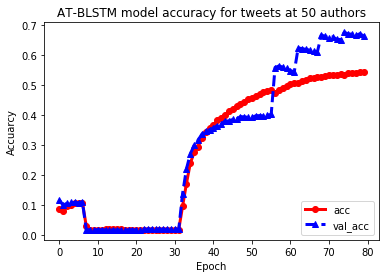

In [58]:
plt.plot(df_tweets.index, df_tweets['acc'], 'go-', color='red', label= 'acc',linewidth=3)
plt.plot(df_tweets.index, df_tweets['val_acc'], '--^', color='blue',label= 'val_acc',linewidth=3)
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuarcy')
plt.savefig(modelsource + 'Tweet2_acc.png')
plt.title('AT-BLSTM model accuracy for tweets at 50 authors')

Text(0.5, 1, 'AT-BLSTM model loss for tweets at 50 authors')

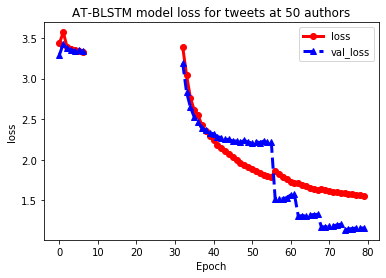

In [59]:
plt.plot(df_tweets.index, df_tweets['loss'], 'go-', color='red', label= 'loss',linewidth=3)
plt.plot(df_tweets.index, df_tweets['val_loss'], '--^', color='blue',label= 'val_loss',linewidth=3)
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.savefig(modelsource + 'tweets2_loss.png')
plt.title('AT-BLSTM model loss for tweets at 50 authors')

Text(0.5, 1, 'AT-BLSTM model F-score for tweets at 50 authors')

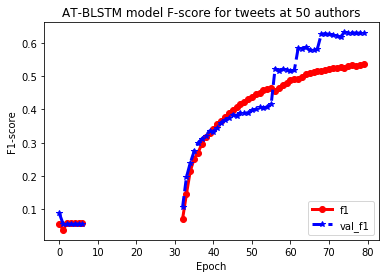

In [60]:
plt.plot(df_tweets.index, df_tweets['f1'], 'go-', color='red', label= 'f1',linewidth=3)
plt.plot(df_tweets.index, df_tweets['val_f1'], '--*', color='blue',label= 'val_f1',linewidth=3)
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.savefig(modelsource + 'tweets2_F1-score.png')
plt.title('AT-BLSTM model F-score for tweets at 50 authors')

In [37]:
k = 5
scores = []
num_validation_sample = len(x_train)//k
for i in range(k):
    print("-----------------------------")
    print('Processing fold #', i)
    print("-----------------------------")
    val_data = x_train[i * num_validation_sample: (i + 1) * num_validation_sample]
    val_lab  = y_train[i * num_validation_sample: (i + 1) * num_validation_sample]
    
    parttial_train_X_data = np.concatenate(
                [x_train[:i * num_validation_sample],
                x_train[(i + 1) * num_validation_sample:]], axis=0)
    
    parttial_train_X_label = np.concatenate(
                [y_train[:i * num_validation_sample],
                y_train[(i + 1) * num_validation_sample:]], axis=0)
    
#     with tf.device('/XLA_GPU:0'):
    history_tweet_atten = model_tweets_adamw.fit(parttial_train_X_data, parttial_train_X_label, 
                               validation_data=(val_data,val_lab),
                               batch_size=batch_size,epochs=num_epochs,
                               verbose=1,
                               callbacks=[reduce_lr_adam,earlystop,
                                          csv_logger])

-----------------------------
Processing fold # 0
-----------------------------
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 66833 samples, validate on 16708 samples
Epoch 1/100
66833/66833 [==============================] - 1840s 28ms/step - loss: 3.4340 - acc: 0.0838 - f1: 0.0587 - val_loss: 3.2453 - val_acc: 0.1281 - val_f1: 0.0836
Epoch 2/100
66833/66833 [==============================] - 1837s 27ms/step - loss: 3.1065 - acc: 0.1585 - f1: 0.1302 - val_loss: 2.9647 - val_acc: 0.1849 - val_f1: 0.1583
Epoch 3/100
66833/66833 [==============================] - 1840s 28ms/step - loss: 2.8363 - acc: 0.2186 - f1: 0.1988 - val_loss: 2.7577 - val_acc: 0.2441 - val_f1: 0.2348
Epoch 4/100
66833/66833 [==============================] - 1839s 28ms/step - loss: 2.6510 - acc: 0.2687 - f1: 0.2508 - val_loss: 2.6597 - val_acc: 0.2739 - val_f1: 0.2728
Epoch 5/100
66833/66833 [==============================] - 1838s 28ms/step - loss: 2.5287 - 

In [38]:
#Print average acc
average_acc = np.mean(history_tweet_atten.history['acc'])
print(average_acc)
print("------------")
#Print average val_acc
average_val_acc = np.mean(history_tweet_atten.history['val_acc'])
print(average_val_acc)
print("------------")

0.5419253961401321
------------
0.6791756444494491
------------


In [39]:
#Print average loss
average_loss = np.mean(history_tweet_atten.history['loss'])
print(average_loss)
print("------------")
#Print average val_loss
average_val_loss = np.mean(history_tweet_atten.history['val_loss'])
print(average_val_loss)
print("------------")

1.5627534666978409
------------
1.1123293566309953
------------


In [40]:
#Print average f1-score
average_f1 = np.mean(history_tweet_atten.history['f1'])
print(average_f1)
print("------------")
#Print average val_f1-score
average_val_f1 = np.mean(history_tweet_atten.history['val_f1'])
print(average_val_f1)
print("------------")

0.531610505745382
------------
0.6399468142373079
------------


In [49]:
# Evaluate the Model on the 20% Validation Dataset
score = model_tweets_adamw.evaluate(val_data, val_lab, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

16708/16708 [==============================] - 103s 6ms/step
Test loss: 1.1601726650578112
Test accuracy: 0.6640531481924826


In [50]:
prediction_value = model_tweets_adamw.predict(x_val)
predict_class = np.argmax(prediction_value, axis=-1)
y_test_integer = np.argmax(y_val, axis=1)

# Detailed analysis
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_integer, predict_class))

              precision    recall  f1-score   support

           0       0.22      0.09      0.12       353
           1       0.50      0.30      0.38       623
           2       0.36      0.38      0.37       631
           3       0.44      0.42      0.43       290
           4       0.81      0.71      0.76       636
           5       0.25      0.11      0.15       566
           6       0.16      0.20      0.18       594
           7       0.14      0.12      0.13        95
           8       0.49      0.27      0.35       155
           9       0.68      0.70      0.69       609
          10       0.49      0.37      0.43       195
          11       0.32      0.28      0.30       622
          12       0.34      0.48      0.40       602
          13       0.17      0.11      0.13       659
          14       0.62      0.64      0.63       611
          15       0.98      0.95      0.96       300
          16       0.43      0.39      0.41       640
          17       0.24    

/home/ds-nlp/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Plot

In [44]:
modelsource = '../../save_models/tweets/'
df_tweets = pd.read_csv(modelsource +'/tweetsAdamW.csv', sep=';' )

In [45]:
df_tweets.head(50)

,epoch,acc,f1,loss,lr,val_acc,val_f1,val_loss
0,0,0.059147,0.023525,3.542736,0.00100,0.103124,0.051664,3.362017
1,1,0.100639,0.057164,3.361503,0.00100,0.104441,0.057950,3.352301
2,2,0.115063,0.063310,3.302519,0.00100,0.124910,0.070854,3.254966
3,3,0.125671,0.072763,3.245564,0.00100,0.128441,0.087883,3.214341
4,4,0.136834,0.092026,3.201947,0.00100,0.145559,0.106031,3.176942
5,5,0.146395,0.109232,3.174331,0.00100,0.152203,0.115916,3.156507
6,6,0.150539,0.116729,3.155013,0.00100,0.152921,0.119625,3.150083
7,7,0.154834,0.121805,3.143590,0.00100,0.156632,0.125239,3.138338
8,8,0.159128,0.124296,3.124369,0.00100,0.156572,0.123475,3.137339
9,9,0.161567,0.128098,3.110317,0.00100,0.156512,0.140181,3.141159


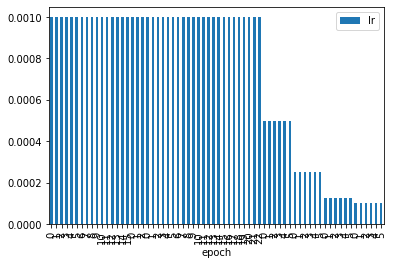

In [46]:
# Learning rate plot
df_tweets.plot('epoch','lr',kind='bar')

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Text(0.5, 1, 'AT-BLSTM model accuracy for tweets at 50 authors')

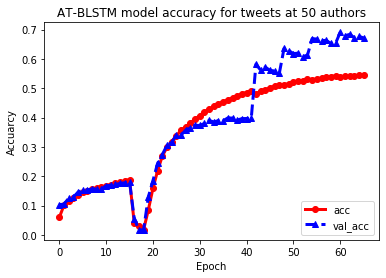

In [48]:
plt.plot(df_tweets.index, df_tweets['acc'], 'go-', color='red', label= 'acc',linewidth=3)
plt.plot(df_tweets.idf_tweetsx, df_tweets['val_acc'], '--^', color='blue',label= 'val_acc',linewidth=3)
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuarcy')
plt.savefig(modelsource + 'Tweet_acc.png')
plt.title('AT-BLSTM model accuracy for tweets at 50 authors')

Text(0.5, 1, 'AT-BLSTM model loss for tweets at 50 authors')

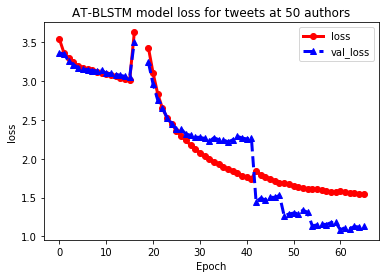

In [49]:
plt.plot(df_tweets.index, df_tweets['loss'], 'go-', color='red', label= 'loss',linewidth=3)
plt.plot(df_tweets.index, df_tweets['val_loss'], '--^', color='blue',label= 'val_loss',linewidth=3)
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.savefig(modelsource + 'tweets_loss.png')
plt.title('AT-BLSTM model loss for tweets at 50 authors')

Text(0.5, 1, 'AT-BLSTM model F-score for tweets at 50 authors')

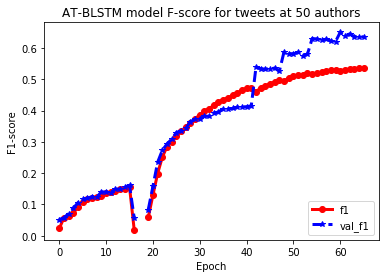

In [50]:
plt.plot(df_tweets.index, df_tweets['f1'], 'go-', color='red', label= 'f1',linewidth=3)
plt.plot(df_tweets.index, df_tweets['val_f1'], '--*', color='blue',label= 'val_f1',linewidth=3)
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.savefig(modelsource + 'tweets_F1-score.png')
plt.title('AT-BLSTM model F-score for tweets at 50 authors')

# 2. SGDW

In [63]:
from SGDW import SGDW
model_tweets_SGDW = build_cnn()
b, B, T = batch_size, x_train.shape[0], num_epochs
wd = 0.0025 * (b/B/T)**0.5
model_tweets_SGDW.compile(loss='categorical_crossentropy',
                 optimizer=SGDW(weight_decay=wd, momentum=0.9),
                 metrics=['accuracy',f1])

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input2 (InputLayer)     (None, 15, 512)           0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 128)           458216    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 15, 512)           788480    
_________________________________________________________________
attention_with_context_3 (At (None, 512)               263168    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 43)                2795

In [66]:
# save model
model_save_dir = '../../save_models/tweets/'
model_tweets_SGDW.save_weights(model_save_dir+"saved_tweets_model_SGDW.h5")

In [ ]:
k = 5
scores = []
num_validation_sample = len(x_train)//k
for i in range(k):
    print("-----------------------------")
    print('Processing fold #', i)
    print("-----------------------------")
    val_data = x_train[i * num_validation_sample: (i + 1) * num_validation_sample]
    val_lab  = y_train[i * num_validation_sample: (i + 1) * num_validation_sample]
    
    parttial_train_X_data = np.concatenate(
                [x_train[:i * num_validation_sample],
                x_train[(i + 1) * num_validation_sample:]], axis=0)
    
    parttial_train_X_label = np.concatenate(
                [y_train[:i * num_validation_sample],
                y_train[(i + 1) * num_validation_sample:]], axis=0)
    
    history_blog_SGWD = model_tweets_SGDW.fit(parttial_train_X_data, parttial_train_X_label, 
                               validation_data=(val_data,val_lab),
                               batch_size=batch_size,epochs=num_epochs,verbose=1,
                               callbacks=[reduce_lr_sgd,earlystop,csv_logger])

# 3. SGD